In [16]:
import pandas as pd
import os, sys
from collections import Counter
import geopandas as gpd
import pylab as pl
from fiona.crs import from_epsg
import shapely 

% pylab inline

Populating the interactive namespace from numpy and matplotlib


# Turn RDD output into orderly dataframe

In [5]:
df = pd.read_csv('/Users/shay/CUSP/BDM/results.csv', index_col = 0)
df.columns = ['Date_Hour', 'Results']

df['Results'] = df['Results'].apply(lambda x: eval(x))

final = pd.DataFrame()
for row in range(len(df)):
    tempdf = pd.DataFrame.from_dict(df.Results[row], orient = 'index')
    tempdf.reset_index(inplace = True)
    tempdf.columns = ['Station', 'Taxi_Rides']
    tempdf['Date_Hour'] = df.Date_Hour[row]
    final = final.append(tempdf)

final.reset_index(inplace = True, drop=True)
final['Date'] = final['Date_Hour'].apply(lambda x: x.split(', ')[0][1:])
final['Hour'] = final['Date_Hour'].apply(lambda x: x.split(', ')[1][:-1])
final['Station'] = final['Station'].convert_objects(convert_numeric = True)
final['Station'] = final['Station'].apply(lambda x: int(x))
final.drop('Date_Hour', axis = 1, inplace = True)

final.to_csv('finaldf.csv')

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


# Merge with subway delay data

In [7]:
df95 = pd.read_csv('/Users/shay/CUSP/BDM/subway_taxi_project/data/delay_final_95.csv')

final['keycol'] = final.Station.map(lambda x: str(x) + '_') + \
                final.Date.map(lambda x: str(x) + '_') + \
                final.Hour.map(lambda x: str(x))

df95['keycol'] = df95.station.map(lambda x: str(x) + '_') + \
                df95.date.map(lambda x: str(x) + '_') + \
                df95.start_hr.map(lambda x: str(x))

merged = final.merge(df95, left_on = 'keycol', right_on = 'keycol', how = 'right')

merged.set_index('keycol', inplace = True)

# Read in subway shapefile, create 100 foot buffer

In [14]:
filepath = '/Users/shay/CUSP/BDM/subway_taxi_project/data/subwaystations/subwaystations.shp'
subwayst = gpd.read_file(filepath)

In [17]:
subwayst.crs = from_epsg(4326)
subwayst = subwayst.to_crs(epsg = 2263)

In [19]:
subwayst['buffer'] = subwayst.geometry.apply(lambda x: x.buffer(100))
subwayst.set_geometry('buffer', crs = 2263, inplace = True)

# Attach shapes to DataFrame

In [22]:
subwayst.objectid = subwayst.objectid.map(lambda x: int(x))

In [24]:
subwaytaxi = subwayst.merge(final, left_on = 'objectid', right_on = 'Station', how = 'right')

# Some Visualizations

In [33]:
viz_df = subwaytaxi.groupby('Station').mean()
viz_df = viz_df.merge(subwayst)

In [37]:
viz_df.drop(['geometry', 'notes', 'url'], axis = 1, inplace = True)

In [40]:
viz_df = gpd.GeoDataFrame(viz_df, geometry = 'buffer')

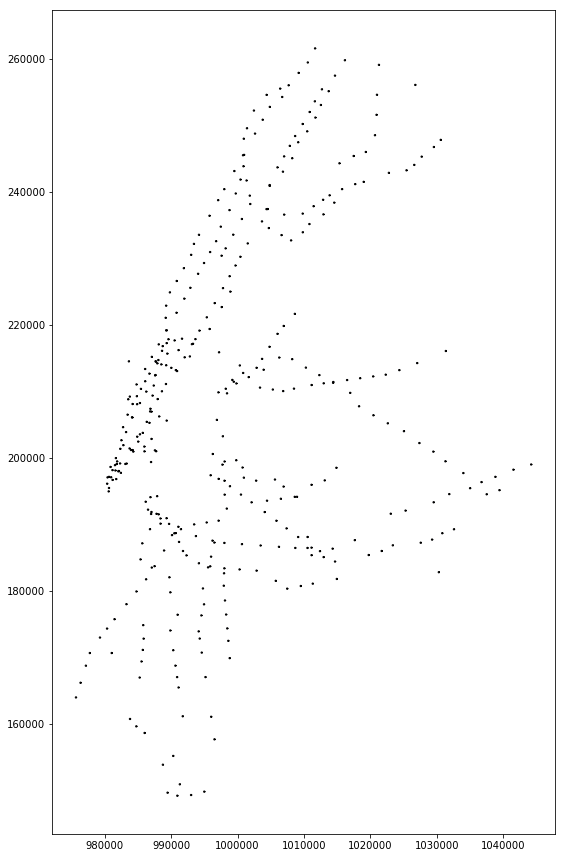

In [74]:
viz_df.plot('Taxi_Rides', figsize = (9, 20), cmap = cm.Blues, scheme = 'quantiles')

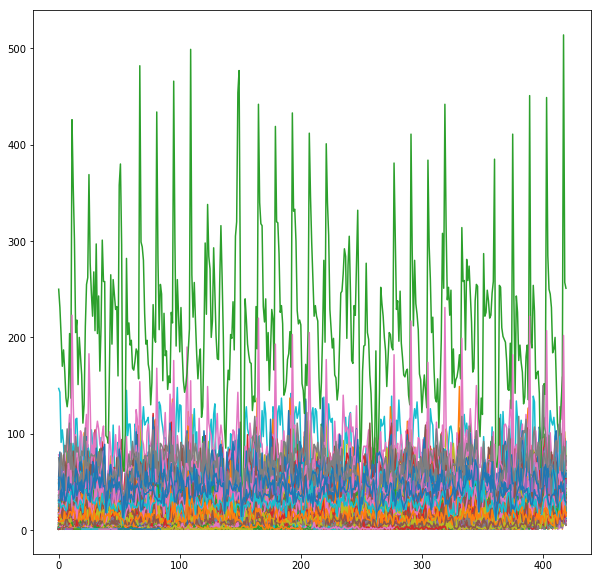

In [63]:
subwaytaxi.sort_values(['Date', 'Hour'], inplace = True)
fig = pl.figure(figsize(10, 10))
for station in subwaytaxi.objectid.unique():
    filterd = subwaytaxi[subwaytaxi.objectid == station]
    pl.plot(range(len(filterd)), filterd.Taxi_Rides, label = filterd.name.iloc[0])

In [76]:
avgsdf = subwaytaxi.groupby('name').mean().sort_values('Taxi_Rides', ascending = False)

In [78]:
delays = subwayst.merge(merged, left_on = 'objectid', right_on = 'Station', how = 'right')

In [95]:
withdelays = delays[delays.delay > 0].groupby('name')[['Taxi_Rides', 'name']].mean().sort_values('Taxi_Rides', ascending = False)

In [96]:
nodelays = delays[delays.delay == 0].groupby('name')[['Taxi_Rides', 'name']].mean().sort_values('Taxi_Rides', ascending = False)

In [100]:
comparison = withdelays.merge(nodelays, left_index = True, right_index = True, suffixes = ('_with', '_without'))

In [107]:
comparison[comparison.Taxi_Rides_with > comparison.Taxi_Rides_without]

,Taxi_Rides_with,Taxi_Rides_without
name,,
Grand Central - 42nd St,57.788618,56.387283
W 4th St - Washington Sq (Upper),24.010204,22.338710
Canal St - Holland Tunnel,17.494297,15.833333
Wall St,9.135802,8.464539
Cathedral Pkwy (110th St),8.652830,7.618321
City Hall,6.615385,5.476341
Queensboro Plz,5.137441,4.906433
Delancey St - Essex St,4.308824,4.231481
Fulton St,3.540084,3.255132


In [106]:
comparison[comparison.Taxi_Rides_with < comparison.Taxi_Rides_without]

,Taxi_Rides_with,Taxi_Rides_without
name,,
50th St,31.777385,33.381356
Astor Pl,26.229268,28.000000
8th St - NYU,23.744681,24.130031
South Ferry,19.111111,19.971698
World Trade Center,14.171123,15.038793
Bowling Green,13.229508,13.632107
Canal St,9.729970,10.448347
Chambers St,4.411765,4.882129
46th St,3.161290,3.590395
